In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('../final_merged_output.csv')
df = df[df['Year'] <= 2022]
#df = df[df['Year'] >= 2010]
chicago = df[df['City'] == 'Chicago']
ny = df[df['City'] == 'New York']
phoenix = df[df['City'] == 'Phoenix']
la = df[df['City'] == 'Los Angeles']
houston = df[df['City'] == 'Houston']
chicago.tail()

,City,Year,Quarter,index_nsa,Median Household Income,Total Population,INDPRO,VIXCLS,CPI,Unemployment Rate,City GDP
127,Chicago,2021,4,214.65,66576.0,2696561.00,100.939133,19.318636,4.697859,4.400000,770533358.0
128,Chicago,2022,1,221.00,67528.5,2688686.75,101.911200,25.349844,8.002800,4.866667,845186849.0
129,Chicago,2022,2,234.20,68481.0,2680812.50,102.896900,27.322077,8.002800,4.633333,845186849.0
130,Chicago,2022,3,235.88,69433.5,2672938.25,103.251133,24.792727,8.002800,4.766667,845186849.0
131,Chicago,2022,4,232.43,70386.0,2665064.00,102.792200,24.945077,8.002800,4.166667,845186849.0


=== KNN Model Performance (Test on 2022) ===
MAE  = 28.1573
RMSE = 28.7544
R²   = -23.3111

Detailed KNN Predictions (2022):
     Year  Quarter  index_nsa    KNN_Pred  Percent_Diff
128  2022        1     221.00  202.716706      8.272984
129  2022        2     234.20  202.726058     13.438916
130  2022        3     235.88  202.720147     14.057933
131  2022        4     232.43  202.718054     12.783180


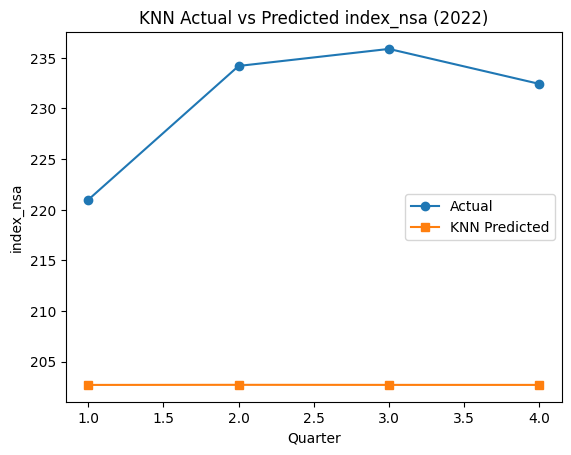

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# =====================================================
# 1. Prepare Data
# =====================================================
# Sort and split data
df = chicago.copy()
df = df.sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Train = up to 2021, Test = 2022
train_df = df[df['Year'] <= 2021]
test_df = df[df['Year'] == 2022]

# Use your top features (from importance ranking)
top_features = [
    'INDPRO',
    'Median Household Income',
    'CPI',
    'Year',
    'City GDP',
    'Unemployment Rate',
    'Total Population'
]

X_train = train_df[top_features]
y_train = train_df['index_nsa']
X_test = test_df[top_features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Scale Features
# ====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Train KNN Model
# =====================================================
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# =====================================================
# 4. valuate Model
# =====================================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=== KNN Model Performance (Test on 2022) ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# =====================================================
# 5. Detailed Predictions
# =====================================================
comparison = test_df.copy()
comparison['KNN_Pred'] = y_pred
comparison['Percent_Diff'] = (
    abs(comparison['KNN_Pred'] - comparison['index_nsa'])
    / comparison['index_nsa'] * 100
)

print("\nDetailed KNN Predictions (2022):")
print(comparison[['Year', 'Quarter', 'index_nsa', 'KNN_Pred', 'Percent_Diff']])

# =====================================================
# 6. Plot Actual vs Predicted
# =====================================================
plt.plot(comparison['Quarter'], comparison['index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['KNN_Pred'], label='KNN Predicted', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('KNN Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()


✅ Best Parameters: k = 2, weights = 'distance'

=== Tuned KNN Model Performance (Test on 2022) ===
MAE  = 18.2741
RMSE = 19.1794
R²   = -9.8159

Detailed KNN Predictions (2022):
     Year  Quarter  index_nsa    KNN_Pred  Percent_Diff
128  2022        1     221.00  212.584103      3.808098
129  2022        2     234.20  212.600539      9.222656
130  2022        3     235.88  212.602255      9.868469
131  2022        4     232.43  212.626613      8.520151


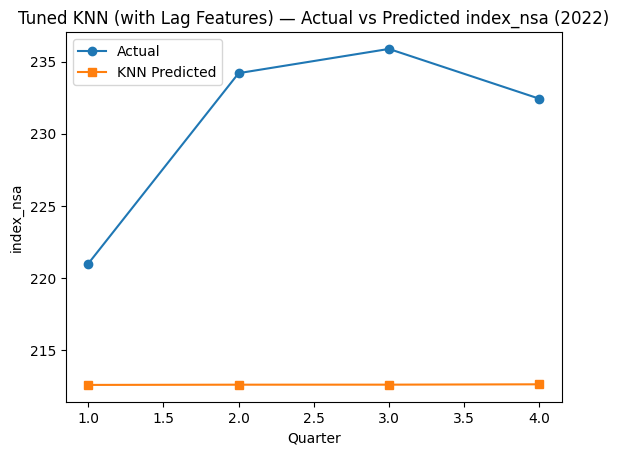

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# =====================================================
# 1. Prepare Data
# =====================================================
df = chicago.copy()
df = df.sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Add lag features for previous quarters
df['Lag1_index'] = df['index_nsa'].shift(1)
df['Lag2_index'] = df['index_nsa'].shift(2)

# Drop rows with NaN lags
df = df.dropna(subset=['Lag1_index', 'Lag2_index'])

# Split data
train_df = df[df['Year'] <= 2021]
test_df = df[df['Year'] == 2022]

# Top features (from your importance results) + lags
features = [
    'INDPRO',
    'City GDP',
    'VIXCLS',
    'Year',
    'Unemployment Rate',
    'Median Household Income',
    'CPI',
    'Total Population',
    'Lag1_index',
    'Lag2_index'
]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Scale Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Hyperparameter Tuning for KNN
# =====================================================
param_grid = {
    'n_neighbors': list(range(2, 11)),
    'weights': ['uniform', 'distance']
}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)

best_k = grid.best_params_['n_neighbors']
best_weights = grid.best_params_['weights']
print(f"✅ Best Parameters: k = {best_k}, weights = '{best_weights}'")

# =====================================================
# 4. Train Final KNN Model
# =====================================================
knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# =====================================================
# 5. Evaluate
# =====================================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n=== Tuned KNN Model Performance (Test on 2022) ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# =====================================================
# 6. Detailed Predictions
# =====================================================
comparison = test_df.copy()
comparison['KNN_Pred'] = y_pred
comparison['Percent_Diff'] = (
    abs(comparison['KNN_Pred'] - comparison['index_nsa'])
    / comparison['index_nsa'] * 100
)

print("\nDetailed KNN Predictions (2022):")
print(comparison[['Year', 'Quarter', 'index_nsa', 'KNN_Pred', 'Percent_Diff']])

# =====================================================
# 7. Plot Actual vs Predicted
# =====================================================
plt.plot(comparison['Quarter'], comparison['index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['KNN_Pred'], label='KNN Predicted', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Tuned KNN (with Lag Features) — Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()


✅ Best Parameters: k = 2, weights = 'distance'

=== Tuned KNN Model Performance (Test on 2022) ===
MAE  = 24.2621
RMSE = 25.6331
R²   = -8.5657

Detailed KNN Predictions (2022):
     Year  Quarter  index_nsa    KNN_Pred  Percent_Diff
128  2022        1     340.14  330.091757      2.954149
129  2022        2     357.90  330.119324      7.762133
130  2022        3     360.75  330.139103      8.485349
131  2022        4     358.74  330.131349      7.974759


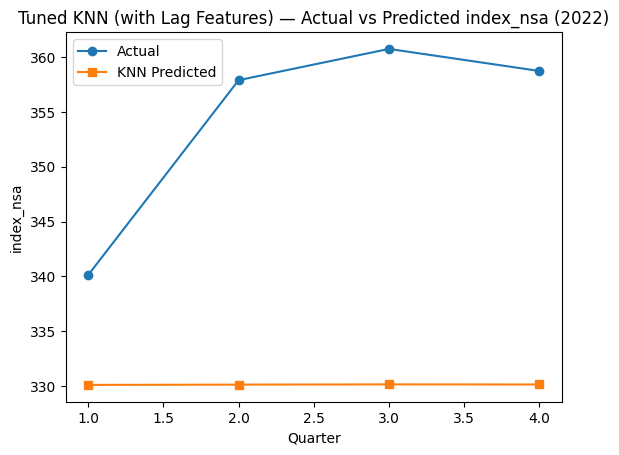

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# =====================================================
# 1. Prepare Data
# =====================================================
df = ny.copy()
df = df.sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Add lag features for previous quarters
df['Lag1_index'] = df['index_nsa'].shift(1)
df['Lag2_index'] = df['index_nsa'].shift(2)

# Drop rows with NaN lags
df = df.dropna(subset=['Lag1_index', 'Lag2_index'])

# Split data
train_df = df[df['Year'] <= 2021]
test_df = df[df['Year'] == 2022]

# Top features (from your importance results) + lags
features = [
    'INDPRO',
    'City GDP',
    'VIXCLS',
    'Year',
    'Unemployment Rate',
    'Median Household Income',
    'CPI',
    'Total Population',
    'Lag1_index',
    'Lag2_index'
]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Scale Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Hyperparameter Tuning for KNN
# =====================================================
param_grid = {
    'n_neighbors': list(range(2, 11)),
    'weights': ['uniform', 'distance']
}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)

best_k = grid.best_params_['n_neighbors']
best_weights = grid.best_params_['weights']
print(f"✅ Best Parameters: k = {best_k}, weights = '{best_weights}'")

# =====================================================
# 4. Train Final KNN Model
# =====================================================
knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# =====================================================
# 5. Evaluate
# =====================================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n=== Tuned KNN Model Performance (Test on 2022) ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# =====================================================
# 6. Detailed Predictions
# =====================================================
comparison = test_df.copy()
comparison['KNN_Pred'] = y_pred
comparison['Percent_Diff'] = (
    abs(comparison['KNN_Pred'] - comparison['index_nsa'])
    / comparison['index_nsa'] * 100
)

print("\nDetailed KNN Predictions (2022):")
print(comparison[['Year', 'Quarter', 'index_nsa', 'KNN_Pred', 'Percent_Diff']])

# =====================================================
# 7. Plot Actual vs Predicted
# =====================================================
plt.plot(comparison['Quarter'], comparison['index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['KNN_Pred'], label='KNN Predicted', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Tuned KNN (with Lag Features) — Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()


✅ Best Parameters: k = 2, weights = 'distance'

=== Tuned KNN Model Performance (Test on 2022) ===
MAE  = 58.2127
RMSE = 60.7049
R²   = -11.4000

Detailed KNN Predictions (2022):
     Year  Quarter  index_nsa    KNN_Pred  Percent_Diff
128  2022        1     457.57  425.006197      7.116682
129  2022        2     495.27  425.067674     14.174556
130  2022        3     502.20  425.104884     15.351477
131  2022        4     478.18  425.190362     11.081525


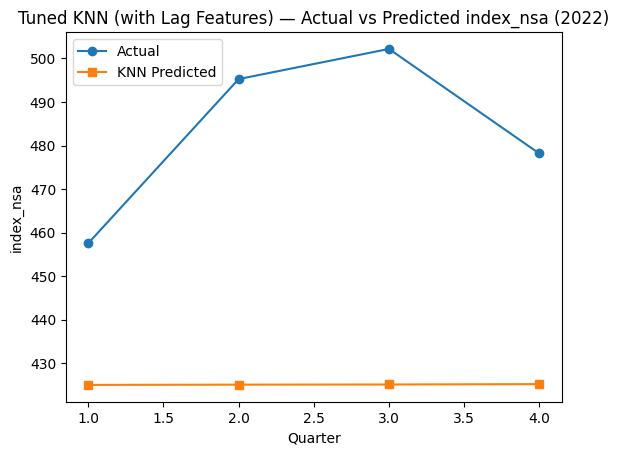

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# =====================================================
# 1. Prepare Data
# =====================================================
df = phoenix.copy()
df = df.sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Add lag features for previous quarters
df['Lag1_index'] = df['index_nsa'].shift(1)
df['Lag2_index'] = df['index_nsa'].shift(2)

# Drop rows with NaN lags
df = df.dropna(subset=['Lag1_index', 'Lag2_index'])

# Split data
train_df = df[df['Year'] <= 2021]
test_df = df[df['Year'] == 2022]

# Top features (from your importance results) + lags
features = [
    'INDPRO',
    'City GDP',
    'VIXCLS',
    'Year',
    'Unemployment Rate',
    'Median Household Income',
    'CPI',
    'Total Population',
    'Lag1_index',
    'Lag2_index'
]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Scale Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Hyperparameter Tuning for KNN
# =====================================================
param_grid = {
    'n_neighbors': list(range(2, 11)),
    'weights': ['uniform', 'distance']
}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)

best_k = grid.best_params_['n_neighbors']
best_weights = grid.best_params_['weights']
print(f"✅ Best Parameters: k = {best_k}, weights = '{best_weights}'")

# =====================================================
# 4. Train Final KNN Model
# =====================================================
knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# =====================================================
# 5. Evaluate
# =====================================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n=== Tuned KNN Model Performance (Test on 2022) ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# =====================================================
# 6. Detailed Predictions
# =====================================================
comparison = test_df.copy()
comparison['KNN_Pred'] = y_pred
comparison['Percent_Diff'] = (
    abs(comparison['KNN_Pred'] - comparison['index_nsa'])
    / comparison['index_nsa'] * 100
)

print("\nDetailed KNN Predictions (2022):")
print(comparison[['Year', 'Quarter', 'index_nsa', 'KNN_Pred', 'Percent_Diff']])

# =====================================================
# 7. Plot Actual vs Predicted
# =====================================================
plt.plot(comparison['Quarter'], comparison['index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['KNN_Pred'], label='KNN Predicted', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Tuned KNN (with Lag Features) — Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()


✅ Best Parameters: k = 10, weights = 'distance'

=== Tuned KNN Model Performance (Test on 2022) ===
MAE  = 104.0710
RMSE = 104.4706
R²   = -75.0124

Detailed KNN Predictions (2022):
     Year  Quarter  index_nsa    KNN_Pred  Percent_Diff
128  2022        1     477.82  385.556962     19.309162
129  2022        2     507.87  391.691036     22.875729
130  2022        3     506.38  397.597235     21.482437
131  2022        4     496.39  397.330885     19.955905


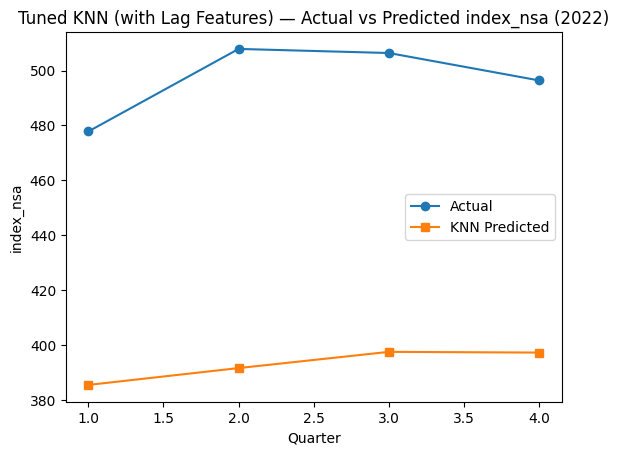

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# =====================================================
# 1. Prepare Data
# =====================================================
df = la.copy()
df = df.sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Add lag features for previous quarters
df['Lag1_index'] = df['index_nsa'].shift(1)
df['Lag2_index'] = df['index_nsa'].shift(2)

# Drop rows with NaN lags
df = df.dropna(subset=['Lag1_index', 'Lag2_index'])

# Split data
train_df = df[df['Year'] <= 2021]
test_df = df[df['Year'] == 2022]

# Top features (from your importance results) + lags
features = [
    'INDPRO',
    'City GDP',
    'VIXCLS',
    'Year',
    'Unemployment Rate',
    'Median Household Income',
    'CPI',
    'Total Population',
    'Lag1_index',
    'Lag2_index'
]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Scale Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Hyperparameter Tuning for KNN
# =====================================================
param_grid = {
    'n_neighbors': list(range(2, 11)),
    'weights': ['uniform', 'distance']
}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)

best_k = grid.best_params_['n_neighbors']
best_weights = grid.best_params_['weights']
print(f"✅ Best Parameters: k = {best_k}, weights = '{best_weights}'")

# =====================================================
# 4. Train Final KNN Model
# =====================================================
knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# =====================================================
# 5. Evaluate
# =====================================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n=== Tuned KNN Model Performance (Test on 2022) ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# =====================================================
# 6. Detailed Predictions
# =====================================================
comparison = test_df.copy()
comparison['KNN_Pred'] = y_pred
comparison['Percent_Diff'] = (
    abs(comparison['KNN_Pred'] - comparison['index_nsa'])
    / comparison['index_nsa'] * 100
)

print("\nDetailed KNN Predictions (2022):")
print(comparison[['Year', 'Quarter', 'index_nsa', 'KNN_Pred', 'Percent_Diff']])

# =====================================================
# 7. Plot Actual vs Predicted
# =====================================================
plt.plot(comparison['Quarter'], comparison['index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['KNN_Pred'], label='KNN Predicted', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Tuned KNN (with Lag Features) — Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()


✅ Best Parameters: k = 2, weights = 'distance'

=== Tuned KNN Model Performance (Test on 2022) ===
MAE  = 36.4012
RMSE = 37.9175
R²   = -11.6795

Detailed KNN Predictions (2022):
     Year  Quarter  index_nsa    KNN_Pred  Percent_Diff
128  2022        1     351.52  331.370663      5.732060
129  2022        2     365.17  331.452353      9.233411
130  2022        3     377.04  331.445390     12.092778
131  2022        4     377.61  331.466734     12.219821


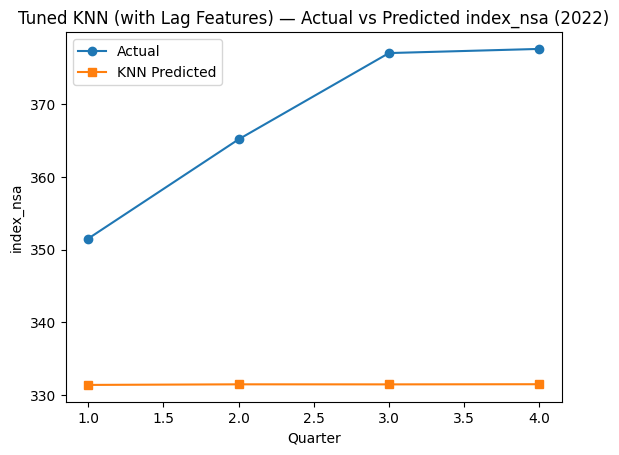

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# =====================================================
# 1. Prepare Data
# =====================================================
df = houston.copy()
df = df.sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Add lag features for previous quarters
df['Lag1_index'] = df['index_nsa'].shift(1)
df['Lag2_index'] = df['index_nsa'].shift(2)

# Drop rows with NaN lags
df = df.dropna(subset=['Lag1_index', 'Lag2_index'])

# Split data
train_df = df[df['Year'] <= 2021]
test_df = df[df['Year'] == 2022]

# Top features (from your importance results) + lags
features = [
    'INDPRO',
    'City GDP',
    'VIXCLS',
    'Year',
    'Unemployment Rate',
    'Median Household Income',
    'CPI',
    'Total Population',
    'Lag1_index',
    'Lag2_index'
]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Scale Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Hyperparameter Tuning for KNN
# =====================================================
param_grid = {
    'n_neighbors': list(range(2, 11)),
    'weights': ['uniform', 'distance']
}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)

best_k = grid.best_params_['n_neighbors']
best_weights = grid.best_params_['weights']
print(f"✅ Best Parameters: k = {best_k}, weights = '{best_weights}'")

# =====================================================
# 4. Train Final KNN Model
# =====================================================
knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# =====================================================
# 5. Evaluate
# =====================================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n=== Tuned KNN Model Performance (Test on 2022) ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# =====================================================
# 6. Detailed Predictions
# =====================================================
comparison = test_df.copy()
comparison['KNN_Pred'] = y_pred
comparison['Percent_Diff'] = (
    abs(comparison['KNN_Pred'] - comparison['index_nsa'])
    / comparison['index_nsa'] * 100
)

print("\nDetailed KNN Predictions (2022):")
print(comparison[['Year', 'Quarter', 'index_nsa', 'KNN_Pred', 'Percent_Diff']])

# =====================================================
# 7. Plot Actual vs Predicted
# =====================================================
plt.plot(comparison['Quarter'], comparison['index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['KNN_Pred'], label='KNN Predicted', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Tuned KNN (with Lag Features) — Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()
